## Dataset preparation

In [1]:
import os
from datetime import datetime
from typing import Callable, Tuple

import cv2
import lpips
import matplotlib.pyplot as plt
import neptune
import numpy as np
import pytorch_msssim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import cuda, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm

In [2]:

class DIV2KDataset(Dataset):
    def __init__(self, root: str, modification=None):
        """
        root        : Ścieżka do katalogu z obrazami .png
        modification: Funkcja (img: torch.Tensor) -> mask
                      Zwraca maskę, którą chcemy wykorzystać w PartialConv.
                      Jeśli None, zwróci maskę = same jedynki.
        """
        self.root = root
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if f.lower().endswith(".png")]
        self.transform = transforms.ToTensor()
        self.modification = modification

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = img.astype(np.float32) / 255.0


        img = self.transform(img)

        if self.modification is not None:
            mask = self.modification(img)
        else:
            C, H, W = img.shape
            mask = torch.ones((C, H, W), dtype=img.dtype)

        return img, mask

In [3]:
def add_random_mask(img: torch.Tensor, mask_size: tuple[int, int] = (64, 64), num_patches: int = 1) -> torch.Tensor:
    C, H, W = img.shape
    mask = torch.ones((C, H, W), dtype=img.dtype)

    for _ in range(num_patches):
        x = np.random.randint(0, W - mask_size[0])
        y = np.random.randint(0, H - mask_size[1])
        mask[:, y : y + mask_size[1], x : x + mask_size[0]] = 0

    return mask

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# %env DIV2K_DATA_PATH=/content/drive/MyDrive/data/DIV2K

In [6]:
DATA_PATH =  os.path.join(os.getcwd(), "..\data\DIV2K")
print(DATA_PATH)

c:\Users\Wiktor\Desktop\SIGK\repo\image-modification\notebooks\..\data\DIV2K


In [7]:
mask_size = (32,32)
num_patches = 1

dataset = DIV2KDataset(
    root=f"{DATA_PATH}/DIV2K_train_HR",
    modification=lambda img: add_random_mask(img, mask_size=mask_size, num_patches=num_patches),
)
train_dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

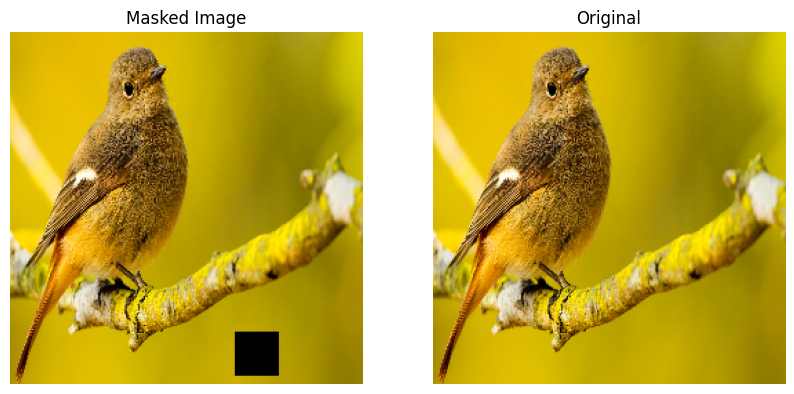

In [8]:
img_batch, mask_batch = next(iter(train_dataloader))

img = img_batch[0]
mask = mask_batch[0]
masked_img = img * mask

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(masked_img.permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Masked Image")
axs[0].axis('off')

axs[1].imshow(img.permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Original")
axs[1].axis('off')

plt.show()

In [9]:
eval_dataset = DIV2KDataset(
    root=f"{DATA_PATH}/DIV2K_valid_HR",
    modification=lambda img: add_random_mask(img, mask_size=mask_size, num_patches=1),
)
eval_dataloader = DataLoader(eval_dataset, batch_size=2, shuffle=True)

## Model definition

In [10]:
###############################################################################
# BSD 3-Clause License
#
# Copyright (c) 2018, NVIDIA CORPORATION. All rights reserved.
#
# Author & Contact: Guilin Liu (guilinl@nvidia.com)
###############################################################################
class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PartialConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])

        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in

                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)


        if self.return_mask:
            return output, self.update_mask
        else:
            return output

In [11]:
class PartialConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pconv1 = PartialConv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True, multi_channel=True, return_mask=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.pconv2 = PartialConv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True, multi_channel=True, return_mask=True)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x, mask):
        x, mask = self.pconv1(x, mask)
        x = self.bn1(x)
        x = self.relu1(x)

        x, mask = self.pconv2(x, mask)
        x = self.bn2(x)
        x = self.relu2(x)
        return x, mask

In [12]:
class PartialDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = PartialConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, mask):
        x_conv, mask_conv = self.block(x, mask)

        out_skip, out_skip_mask = x_conv, mask_conv

        x_down = self.pool(x_conv)
        mask_down = self.pool(mask_conv)

        return (out_skip, out_skip_mask), (x_down, mask_down)

In [13]:
class PartialUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample_x    = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample_mask = nn.Upsample(scale_factor=2, mode='nearest')

        in_c = in_channels + in_channels // 2
        self.block = PartialConvBlock(in_c, out_channels)

    def forward(self, x, x_mask, skip, skip_mask):
        x_up    = self.upsample_x(x)
        mask_up = self.upsample_mask(x_mask)

        x_cat    = torch.cat([x_up, skip], dim=1)
        mask_cat = torch.cat([mask_up, skip_mask], dim=1)

        out, out_mask = self.block(x_cat, mask_cat)
        return out, out_mask

In [14]:
class InpaintingPartialUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        # Encoder
        self.down1 = PartialDown(in_channels, 64)
        self.down2 = PartialDown(64, 128)
        self.down3 = PartialDown(128, 256)
        self.down4 = PartialDown(256, 512)

        # Bottleneck
        self.bottleneck = PartialConvBlock(512, 1024)

        # Decoder
        self.up1 = PartialUp(1024, 512)
        self.up2 = PartialUp(512, 256)
        self.up3 = PartialUp(256, 128)
        self.up4 = PartialUp(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, mask):
        # Encoder
        (skip1, skip1_mask), (d1, d1_mask) = self.down1(x, mask)
        (skip2, skip2_mask), (d2, d2_mask) = self.down2(d1, d1_mask)
        (skip3, skip3_mask), (d3, d3_mask) = self.down3(d2, d2_mask)
        (skip4, skip4_mask), (d4, d4_mask) = self.down4(d3, d3_mask)

        # Bottleneck
        bottleneck, bottleneck_mask = self.bottleneck(d4, d4_mask)

        # Decoder
        up1, up1_mask = self.up1(bottleneck, bottleneck_mask, skip4, skip4_mask)
        up2, up2_mask = self.up2(up1, up1_mask, skip3, skip3_mask)
        up3, up3_mask = self.up3(up2, up2_mask, skip2, skip2_mask)
        up4, up4_mask = self.up4(up3, up3_mask, skip1, skip1_mask)

        out = self.final_conv(up4)
        return out

In [15]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int):
#         super(ConvBlock, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.conv(x)


# class Down(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int):
#         super(Down, self).__init__()
#         self.conv = ConvBlock(in_channels, out_channels)
#         self.pool = nn.MaxPool2d(kernel_size=2)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         features = self.conv(x)
#         pooled = self.pool(features)
#         return features, pooled


# class Up(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int):
#         super(Up, self).__init__()
#         self.upconv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#         self.conv = ConvBlock(in_channels, out_channels)

#     def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
#         x = self.upconv(x)  # Upsample
#         x = torch.cat((x, skip), dim=1)  # Concatenate with skip connection
#         return self.conv(x)

In [16]:
# class InpaintingUNet(nn.Module):
#     """U-Net model for image inpainting"""
#     def __init__(self, in_channels: int = 4, out_channels: int = 3):
#         super(InpaintingUNet, self).__init__()

#         self.down1 = Down(in_channels, 64)
#         self.down2 = Down(64, 128)
#         self.down3 = Down(128, 256)
#         self.down4 = Down(256, 512)

#         self.bottleneck = ConvBlock(512, 1024)

#         self.up1 = Up(1024, 512)
#         self.up2 = Up(512, 256)
#         self.up3 = Up(256, 128)
#         self.up4 = Up(128, 64)

#         self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
#         """
#         Forward pass of the U-Net.
#         :param x: Masked image (B, 3, H, W)
#         :param mask: Binary mask (B, 1, H, W) where 0 = missing pixels, 1 = valid pixels
#         """
#         # Concatenate the mask with the input image along the channel dimension
#         x = torch.cat((x, mask), dim=1)

#         # Encoder (Downsampling)
#         skip1, d1 = self.down1(x)
#         skip2, d2 = self.down2(d1)
#         skip3, d3 = self.down3(d2)
#         skip4, d4 = self.down4(d3)

#         # Bottleneck
#         bottleneck = self.bottleneck(d4)

#         # Decoder (Upsampling with Skip Connections)
#         up1 = self.up1(bottleneck, skip4)
#         up2 = self.up2(up1, skip3)
#         up3 = self.up3(up2, skip2)
#         up4 = self.up4(up3, skip1)

#         return self.final_conv(up4)

In [17]:
class InpaintingLoss(nn.Module):
    def __init__(self, extractor, tv_loss='mean'):
        super(InpaintingLoss, self).__init__()
        self.tv_loss = tv_loss
        self.l1 = nn.L1Loss()
        # default extractor is VGG16
        self.extractor = extractor

    def forward(self, input, mask, output, gt):
        # Non-hole pixels directly set to ground truth
        comp = mask * input + (1 - mask) * output

        # Total Variation Regularization
        tv_loss = total_variation_loss(comp, mask, self.tv_loss)
        # tv_loss = (torch.mean(torch.abs(comp[:, :, :, :-1] - comp[:, :, :, 1:])) \
        #           + torch.mean(torch.abs(comp[:, :, :, 1:] - comp[:, :, :, :-1])) \
        #           + torch.mean(torch.abs(comp[:, :, :-1, :] - comp[:, :, 1:, :])) \
        #           + torch.mean(torch.abs(comp[:, :, 1:, :] - comp[:, :, :-1, :]))) / 2

        # Hole Pixel Loss
        hole_loss = self.l1((1-mask) * output, (1-mask) * gt)

        # Valid Pixel Loss
        valid_loss = self.l1(mask * output, mask * gt)

        # Perceptual Loss and Style Loss
        feats_out = self.extractor(output)
        feats_comp = self.extractor(comp)
        feats_gt = self.extractor(gt)
        perc_loss = 0.0
        style_loss = 0.0
        # Calculate the L1Loss for each feature map
        for i in range(3):
            perc_loss += self.l1(feats_out[i], feats_gt[i])
            perc_loss += self.l1(feats_comp[i], feats_gt[i])
            style_loss += self.l1(gram_matrix(feats_out[i]),
                                  gram_matrix(feats_gt[i]))
            style_loss += self.l1(gram_matrix(feats_comp[i]),
                                  gram_matrix(feats_gt[i]))

        return {'valid': valid_loss,
                'hole': hole_loss,
                'perc': perc_loss,
                'style': style_loss,
                'tv': tv_loss}


# The network of extracting the feature for perceptual and style loss
class VGG16FeatureExtractor(nn.Module):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)
        normalization = Normalization(self.MEAN, self.STD)
        # Define the each feature exractor
        self.enc_1 = nn.Sequential(normalization, *vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        # fix the encoder
        for i in range(3):
            for param in getattr(self, 'enc_{}'.format(i+1)).parameters():
                param.requires_grad = False

    def forward(self, input):
        feature_maps = [input]
        for i in range(3):
            feature_map = getattr(self, 'enc_{}'.format(i+1))(feature_maps[-1])
            feature_maps.append(feature_map)
        return feature_maps[1:]


# Normalization Layer for VGG
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, input):
        # normalize img
        if self.mean.type() != input.type():
            self.mean = self.mean.to(input)
            self.std = self.std.to(input)
        return (input - self.mean) / self.std


# Calcurate the Gram Matrix of feature maps
def gram_matrix(feat):
    (b, ch, h, w) = feat.size()
    feat = feat.view(b, ch, h * w)
    feat_t = feat.transpose(1, 2)
    gram = torch.bmm(feat, feat_t) / (ch * h * w)
    return gram


def dialation_holes(hole_mask):
    b, ch, h, w = hole_mask.shape
    dilation_conv = nn.Conv2d(ch, ch, 3, padding=1, bias=False).to(hole_mask)
    torch.nn.init.constant_(dilation_conv.weight, 1.0)
    with torch.no_grad():
        output_mask = dilation_conv(hole_mask)
    updated_holes = output_mask != 0
    return updated_holes.float()


def total_variation_loss(image, mask, method):
    hole_mask = 1 - mask
    dilated_holes = dialation_holes(hole_mask)
    colomns_in_Pset = dilated_holes[:, :, :, 1:] * dilated_holes[:, :, :, :-1]
    rows_in_Pset = dilated_holes[:, :, 1:, :] * dilated_holes[:, :, :-1:, :]
    if method == 'sum':
        loss = torch.sum(torch.abs(colomns_in_Pset*(
                    image[:, :, :, 1:] - image[:, :, :, :-1]))) + \
            torch.sum(torch.abs(rows_in_Pset*(
                    image[:, :, :1, :] - image[:, :, -1:, :])))
    else:
        loss = torch.mean(torch.abs(colomns_in_Pset*(
                    image[:, :, :, 1:] - image[:, :, :, :-1]))) + \
            torch.mean(torch.abs(rows_in_Pset*(
                    image[:, :, :1, :] - image[:, :, -1:, :])))
    return loss

In [18]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:16]
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.eval()

    def forward(self, denoised, gt):
        denoised_features = self.vgg(denoised)
        gt_features = self.vgg(gt)
        loss = F.mse_loss(denoised_features, gt_features)
        return loss

## Evaluation Setup

In [19]:
# !pip install -q pytorch-msssim
# !pip install -q lpips

In [20]:

ssim_loss = pytorch_msssim.SSIM(data_range=1.0, size_average=True, channel=3)
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
lpips_metric = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\Wiktor\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Wiktor\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Wiktor\AppData\Local\Programs\Python\Python311\Lib\site-packages\lpips\weights\v0.1\vgg.pth


In [21]:
def psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    """
    Computes the Peak Signal-to-Noise Ratio (PSNR) between two images.
    """
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float("inf")
    max_pixel = 1.0
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))

def evaluate_psnr(model: nn.Module, dataloader: DataLoader, device: str) -> float:
    """
    Evaluates the model on the test dataset using PSNR.
    """
    model.eval()
    total_psnr = 0
    num_batches = 0

    with torch.no_grad():
        for clean_imgs, masks in dataloader:
            masks = masks.to(device)
            clean_imgs = clean_imgs.to(device)
            masked_imgs = clean_imgs * masks

            inpainted_imgs = model(masked_imgs, masks)
            batch_psnr = psnr(inpainted_imgs, clean_imgs)

            total_psnr += batch_psnr.item()
            num_batches += 1

    avg_psnr = total_psnr / num_batches
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    return avg_psnr

def evaluate_lpips(model: nn.Module, dataloader: DataLoader, device: str) -> float:
    model.eval()
    total_lpips = 0
    num_batches = 0

    with torch.no_grad():
        for clean_imgs, masks in dataloader:
            masks = masks.to(device)
            clean_imgs = clean_imgs.to(device)
            masked_imgs = clean_imgs * masks

            inpainted_imgs = model(masked_imgs, masks)
            batch_lpips = lpips_metric(inpainted_imgs, clean_imgs).mean()

            total_lpips += batch_lpips.item()
            num_batches += 1

    avg_lpips = total_lpips / num_batches
    print(f"Average LPIPS: {avg_lpips:.4f}")
    return avg_lpips

def evaluate_ssim(model: nn.Module, dataloader: DataLoader, device: str) -> float:
    model.eval()
    model.to(device)
    total_ssim = 0
    num_batches = 0

    with torch.no_grad():
        for clean_imgs, masks in dataloader:
            masks = masks.to(device)
            clean_imgs = clean_imgs.to(device)
            masked_imgs = clean_imgs * masks

            inpainted_imgs = model(masked_imgs, masks)
            batch_ssim = ssim_loss(inpainted_imgs, clean_imgs)

            total_ssim += batch_ssim.item()
            num_batches += 1

    avg_ssim = total_ssim / num_batches
    print(f"Average SSIM: {avg_ssim:.4f}")
    return avg_ssim

In [22]:
def visualize_inpainting(model, dataloader, device, num_images=2):
    """
    Zakładamy, że nasz dataset zwraca (img, mask),
    gdzie:
      - img  ma rozmiar [B, C, H, W]
      - mask ma rozmiar [B, C, H, W]
    i że maska = 1 w miejscach dostępnych,
      maska = 0 w miejscach do inpaintingu.
    """
    model.eval()
    with torch.no_grad():
        img_batch, mask_batch = next(iter(dataloader))
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        masked_imgs = img_batch * mask_batch

        inpainted_imgs = model(masked_imgs, mask_batch)
        inpainted_imgs = inpainted_imgs.cpu().permute(0, 2, 3, 1).numpy()

    masked_imgs = masked_imgs.cpu().permute(0, 2, 3, 1).numpy()
    clean_imgs = img_batch.cpu().permute(0, 2, 3, 1).numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(10, 3 * num_images))

    for i in range(num_images):
        # Masked input
        axes[i, 0].imshow(masked_imgs[i])
        axes[i, 0].set_title("Masked Input")
        axes[i, 0].axis("off")

        # Model output
        min_val = inpainted_imgs[i].min()
        max_val = inpainted_imgs[i].max()
        inpainted_img = (inpainted_imgs[i] - min_val) / (max_val - min_val)
        axes[i, 1].imshow(inpainted_img)
        axes[i, 1].set_title("Inpainted Output")
        axes[i, 1].axis("off")

        # Ground truth
        axes[i, 2].imshow(clean_imgs[i])
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

    return fig


## Experiment Tracking Setup

In [23]:
# ! pip install -q neptune

In [24]:
NEPTUNE_PROJECT_NAME = "sigk/image-inpainting"
NEPTUNE_API_KEY = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ODA4YThkMy04N2Y5LTQ4NzItYmExMi1hNDdkM2Y4ZTJiNWYifQ=="

## Training

In [25]:
# %env MODEL_CHECKPOINTS_PATH=/content/drive/MyDrive/studia/sigk/model_checkpoints

In [26]:
# checkpoints_path = os.getenv("MODEL_CHECKPOINTS_PATH")

In [27]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [28]:
def train_inpainting(
    model: nn.Module,
    dataloader,
    optimizer,
    inpaint_criterion,
    device: str,
    epochs: int = 5,
    run: neptune.Run | None = None,
):
    model.to(device)
    model.train()

    weight_valid = 1.0
    weight_hole  = 6.0
    weight_tv    = 0.1
    weight_perc  = 0.05
    weight_style = 120.0

    # optimizer = optim.Adam(model.parameters(), lr=lr)

    # scaler = torch.cuda.amp.GradScaler() if str(device).startswith('cuda') else None
    scaler = None

    for epoch in range(epochs):
        epoch_loss = 0.0
        for img, mask in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            img  = img.to(device)
            mask = mask.to(device)
            masked_img = img * mask

            optimizer.zero_grad()

            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output = model(masked_img, mask)
                    loss_dict = inpaint_criterion(masked_img, mask, output, img)

                    loss = (
                        weight_valid * loss_dict['valid'] +
                        weight_hole  * loss_dict['hole']  +
                        weight_tv    * loss_dict['tv']    +
                        weight_perc  * loss_dict['perc']  +
                        weight_style * loss_dict['style']
                    )
            else:
                output = model(masked_img, mask)
                loss_dict = inpaint_criterion(masked_img, mask, output, img)
                loss = (
                    weight_valid * loss_dict['valid'] +
                    weight_hole  * loss_dict['hole']  +
                    weight_tv    * loss_dict['tv']    +
                    weight_perc  * loss_dict['perc']  +
                    weight_style * loss_dict['style']
                )

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            if run:
                run["train/batch/loss"].append(loss.item())
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")
        if run:
            run["train/epoch/loss"].append(epoch_loss)

    return model

In [29]:
# def train_inpainting(
#     model: nn.Module,
#     dataloader,
#     inpaint_criterion,  # -> nasza InpaintingLoss
#     device: str,
#     epochs: int = 5,
#     run: neptune.Run | None = None,
# ):
#     model.to(device)
#     model.train()

#     # scaler = torch.amp.GradScaler() if str(device).startswith("cuda") else None
#     scaler = None

#     for epoch in range(epochs):
#         epoch_loss = 0.0
#         for img, mask in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
#             img = img.to(device)  # [B,3,H,W]
#             mask = mask.to(device)  # [B,3,H,W] lub [B,1,H,W]
#             masked_img = img * mask  # wycinamy dziurę

#             optimizer.zero_grad()

#             # Używamy mixed precision, jeśli mamy GPU
#             if scaler is not None:
#                 with torch.amp.autocast("cuda"):
#                     output = model(masked_img, mask)
#                     loss = inpaint_criterion(output, img)

#             else:
#                 output = model(masked_img, mask)
#                 loss = inpaint_criterion(output, img)

#             # backprop + opt step
#             if scaler is not None:
#                 scaler.scale(loss).backward()
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 loss.backward()
#                 optimizer.step()

#             if run:
#                 run["train/batch/loss"].append(loss.item())
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(dataloader)
#         print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")
#         if run:
#             run["train/epoch/loss"].append(epoch_loss)

#     return model

In [30]:
model = InpaintingPartialUNet(in_channels=3, out_channels=3)
# model = torch.compile(model)
model = model.to(device)

perceptual_loss = PerceptualLoss().to(device)
mse_loss = nn.MSELoss()
# criterion = lambda x, y: mse_loss(x, y) + 0.1 * perceptual_loss(x, y)
vgg_extractor = VGG16FeatureExtractor().to(device)
criterion = InpaintingLoss(extractor=vgg_extractor, tv_loss='mean').to(device)

lr = 0.0002
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 1

In [31]:
run = neptune.init_run(
    project=NEPTUNE_PROJECT_NAME,
    api_token=NEPTUNE_API_KEY,
)
params = {
    "model_name": model.__class__.__name__,
    "optimizer_name": optimizer.__class__.__name__,
    "loss_function": "MSELoss+PerceptualLoss",
    "learning_rate": lr,
    "epochs": epochs
}
run["parameters"] = params
run["dataset/num_patches"] = num_patches
run["dataset/mask_size"] = str(mask_size)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sigk/image-inpainting/e/IMPAINT-52


In [32]:
start_time = datetime.now()
model = train_inpainting(model, train_dataloader, optimizer, criterion, device, epochs=epochs, run=run)
train_time = datetime.now() - start_time
print(f"Training time: {train_time}")
run["train/time"] = train_time.seconds

Epoch 1/1: 100%|██████████| 400/400 [04:34<00:00,  1.46it/s]

Epoch [1/1] - Loss: 7.2487
Training time: 0:04:34.837087


In [33]:
CHECKPOINT_PATH =  os.path.join(os.getcwd(), "checkpoints")
print(CHECKPOINT_PATH)

c:\Users\Wiktor\Desktop\SIGK\repo\image-modification\notebooks\checkpoints


In [34]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = f"{CHECKPOINT_PATH}\\InpaintingUNet_{timestamp}.pt"
torch.save(model, model_path)

In [35]:
# checkpoints_path = os.getenv("MODEL_CHECKPOINTS_PATH")
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# os.makedirs(f"{checkpoints_path}/{model.__class__.__name__}/{timestamp}")
# model_path = f"{checkpoints_path}/{model.__class__.__name__}/{timestamp}/model.pt"
# torch.save(model, model_path)

In [56]:
# model = torch.load(f'{CHECKPOINT_PATH}\\InpaintingUNet_2025-03-23_22-39-59.pt', weights_only=False)
model = torch.load(f'{CHECKPOINT_PATH}\\InpaintingUNet_2025-03-24_16-32-22.pt', weights_only=False)
model.eval()

InpaintingPartialUNet(
  (down1): PartialDown(
    (block): PartialConvBlock(
      (pconv1): PartialConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pconv2): PartialConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): PartialDown(
    (block): PartialConvBlock(
      (pconv1): PartialConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pconv2): PartialConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, 

In [57]:
run["model/saved_model"].upload(model_path)
run["model/params"] = sum(p.numel() for p in model.parameters())

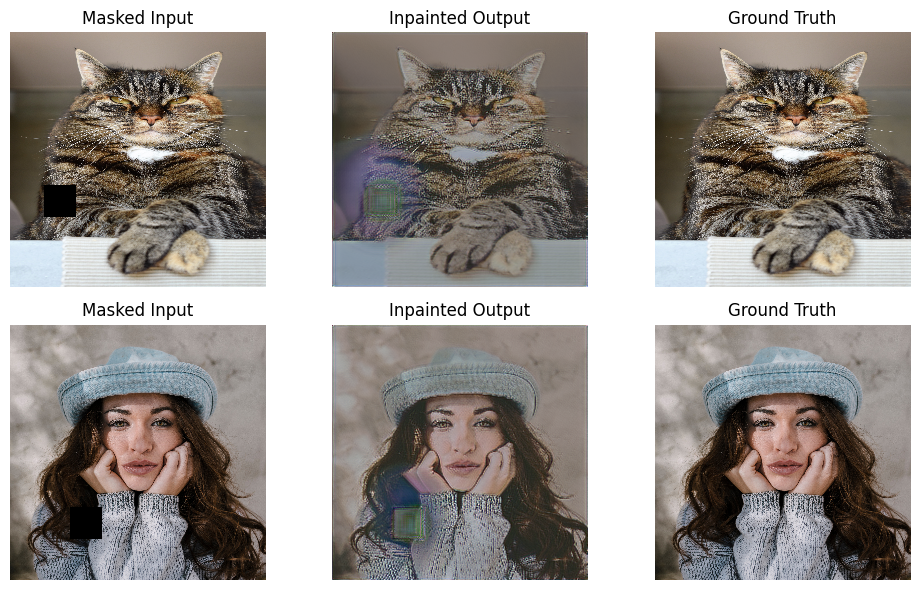

In [68]:
fig = visualize_inpainting(model, eval_dataloader, device)

In [39]:
run["eval/sample_preds"].upload(fig)

In [40]:
avg_psnr = evaluate_psnr(model, eval_dataloader, device)
avg_ssim = evaluate_ssim(model, eval_dataloader, device)
avg_lpips = evaluate_lpips(model, eval_dataloader, device)
run["eval/psnr"] =  avg_psnr
run["eval/ssim"] = avg_ssim
run["eval/lpips"] = avg_lpips

Average PSNR: 16.01 dB
Average SSIM: 0.4963
Average LPIPS: 0.2082


In [41]:
run["dataset/train"].track_files(f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_train_HR")
run["dataset/eval"].track_files(f"{os.getenv('DIV2K_DATA_PATH')}/DIV2K_valid_HR")

In [69]:
# run.stop()

## Baseline

In [70]:
class OpenCVInpainting(nn.Module):
    def __init__(self, inpaint_radius=3):
        super(OpenCVInpainting, self).__init__()
        self.inpaint_radius = inpaint_radius

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Apply OpenCV's inpainting to a batch of images.
        :param x: Input tensor of shape (B, C, H, W) with masked regions.
        :param mask: Binary mask tensor of shape (B, 1, H, W), where 0 = missing areas, 1 = valid pixels.
        :return: Inpainted tensor of shape (B, C, H, W).
        """
        x = x * mask
        x_np = x.cpu().numpy()
        mask_np = mask.cpu().numpy()

        inpainted_images = np.zeros_like(x_np)

        for i in range(x_np.shape[0]):  # Process each image in batch separately
            for c in range(x_np.shape[1]):  # Process each color channel separately
                # Convert mask to OpenCV format (H, W) with values in {0, 255}
                opencv_mask = (1 - mask_np[i, 0]) * 255  # Invert mask: 0 → hole, 255 → valid

                inpainted_images[i, c] = cv2.inpaint(
                    x_np[i, c],  # Single channel of image
                    opencv_mask.astype(np.uint8),  # OpenCV mask (0 for valid, 255 for missing)
                    self.inpaint_radius,
                    cv2.INPAINT_TELEA  # Telea’s algorithm for inpainting
                )

        return torch.tensor(inpainted_images, dtype=torch.float32, device=x.device)  # Convert back to tensor


In [71]:
inpaint_radius = 10
model = OpenCVInpainting(inpaint_radius).to(device)

In [72]:
run = neptune.init_run(
    project=NEPTUNE_PROJECT_NAME,
    api_token=NEPTUNE_API_KEY,
    tags=["baseline"],
)
params = {
    "model_name": model.__class__.__name__,
    "inpaint_radius": inpaint_radius,
}
run["parameters"] = params
run["dataset/num_patches"] = num_patches
run["dataset/mask_size"] = str(mask_size)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sigk/image-inpainting/e/IMPAINT-55


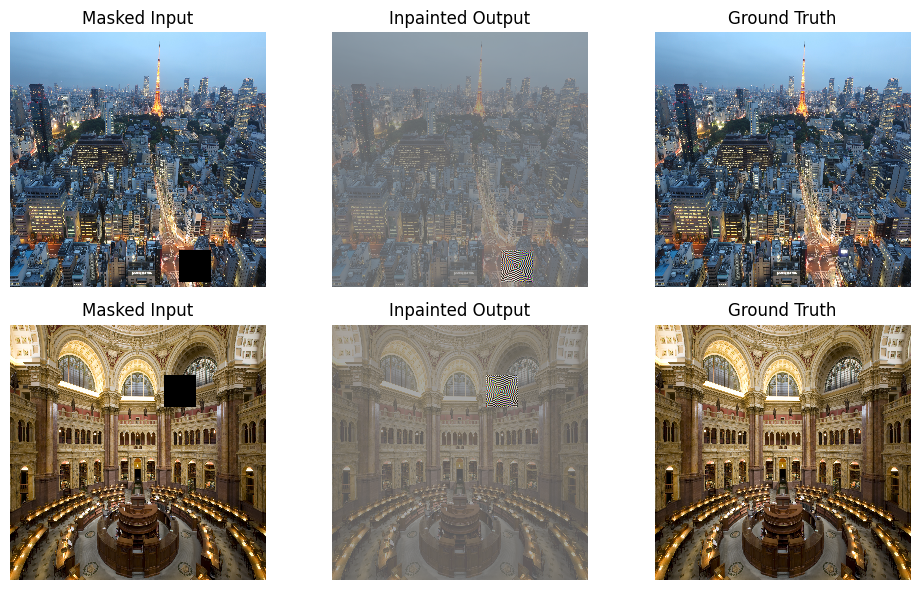

In [73]:
fig = visualize_inpainting(model, eval_dataloader, device)

In [74]:
run["eval/sample_preds"].upload(fig)

In [75]:
avg_psnr = evaluate_psnr(model, eval_dataloader, device)
avg_ssim = evaluate_ssim(model, eval_dataloader, device)
avg_lpips = evaluate_lpips(model, eval_dataloader, device)
run["eval/psnr"] =  avg_psnr
run["eval/ssim"] = avg_ssim
run["eval/lpips"] = avg_lpips

Average PSNR: 18.09 dB
Average SSIM: 0.9769
Average LPIPS: 0.0375
